In [2]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from heapy.data.retrieve import gbmRetrieve
from heapy.geos.geometry import gbmGeometry
from heapy.pipe.event import gbmTTE
from heapy.util.data import msg_format, union
from heapy.util.time import fermi_utc_to_met, fermi_utc_goback

In [3]:
utc = '2024-02-19T06:21:42'
fermi_met = fermi_utc_to_met(utc)

gbm_rtv = gbmRetrieve.from_utc(utc=utc, t1=-1800, t2=1800, skip_poshist=True)

In [5]:
goback_utc = '2024-02-17T06:21:42'

gbm_goback_rtv = gbmRetrieve.from_utc(utc=goback_utc, t1=-1800, t2=1800, skip_tte=True)

goback_utc = fermi_utc_goback(utc, poshist_file=gbm_goback_rtv.rtv_res['poshist'][0])
fermi_goback_met = fermi_utc_to_met(goback_utc)

print(goback_utc)

2024-02-17T06:52:57.753


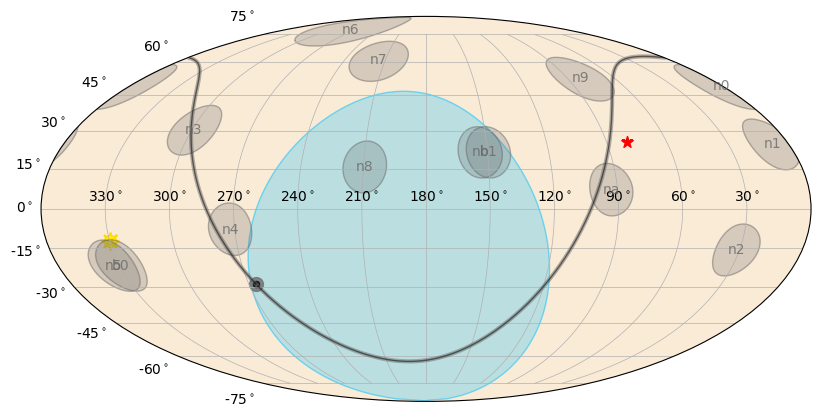

In [6]:
gbm_goback_geo = gbmGeometry(file=gbm_goback_rtv.rtv_res['poshist'])

gbm_goback_geo.extract_skymap(ra=80.016, dec=25.541, met=fermi_goback_met, savepath='./geometry')

In [7]:
gbm_goback_geo = gbmGeometry(file=gbm_goback_rtv.rtv_res['poshist'])

for det in ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'na', 'nb']:
    gbm_tte = gbmTTE(gbm_rtv.rtv_res['tte'][det])
    gbm_tte.timezero = fermi_met
    gbm_tte.filter_time([-1800, 1800])
    if det[0] == 'n': 
        gbm_tte.filter_energy([8, 900])
    else: 
        gbm_tte.filter_energy([300, 38000])
    gbm_tte.lc_binsize = 10

    gbm_saa = gbm_goback_geo.saa_passage(met=gbm_tte.lc_time+fermi_goback_met)
    gbm_sun = gbm_goback_geo.sun_visible(met=gbm_tte.lc_time+fermi_goback_met)
    gbm_loc = gbm_goback_geo.location_visible(ra=80.016, dec=25.541, met=gbm_tte.lc_time+fermi_goback_met)
    gbm_ang = gbm_goback_geo.detector_angle(ra=80.016, dec=25.541, det=det, met=gbm_tte.lc_time+fermi_goback_met)

    roi_list = []
    for i in range(len(gbm_tte.lc_time)):
        if not gbm_saa[i] and gbm_loc[i] and gbm_ang[i] < 60:
            roi_list.append(gbm_tte.lc_bin_list[i])
    roi_list = union(roi_list)
    
    print(msg_format(f'extract light curve for {det}'))
    
    fig = make_subplots(
        rows=5, cols=1,
        row_heights=[0.8, 0.2, 0.2, 0.2, 0.2], 
        shared_xaxes=True,
        horizontal_spacing=0,
        vertical_spacing=0.02)
    
    lc = go.Scatter(x=gbm_tte.lc_time, 
                    y=gbm_tte.lc_src_rate, 
                    mode='lines+markers', 
                    name='lightcurve', 
                    showlegend=True, 
                    error_y=dict(
                        type='data',
                        array=gbm_tte.lc_src_rate_err,
                        thickness=1.5,
                        width=0), 
                    marker=dict(symbol='cross-thin', size=0))
    fig.add_trace(lc, row=1, col=1)
    
    for roi in roi_list:
        fig.add_vrect(x0=roi[0], x1=roi[1], fillcolor='red', opacity=0.2, line_width=0, row=1, col=1)
    
    saa = go.Scatter(x=gbm_tte.lc_time, 
                     y=gbm_saa.astype(int), 
                     mode='lines', 
                     name='SAA passage', 
                     showlegend=True)
    fig.add_trace(saa, row=2, col=1)
    
    sun = go.Scatter(x=gbm_tte.lc_time, 
                     y=gbm_sun.astype(int), 
                     mode='lines', 
                     name='sun visible', 
                     showlegend=True)
    fig.add_trace(sun, row=3, col=1)
    
    loc = go.Scatter(x=gbm_tte.lc_time, 
                     y=gbm_loc.astype(int), 
                     mode='lines', 
                     name='location visible', 
                     showlegend=True)
    fig.add_trace(loc, row=4, col=1)
    
    ang = go.Scatter(x=gbm_tte.lc_time, 
                     y=gbm_ang, 
                     mode='lines', 
                     name='detector angle', 
                     showlegend=True)
    a60 = go.Scatter(x=gbm_tte.lc_time, 
                     y=[60]*len(gbm_tte.lc_time), 
                     mode='lines', 
                     showlegend=False, 
                     line=dict(width=2, dash='dash'))
    fig.add_trace(ang, row=5, col=1)
    fig.add_trace(a60, row=5, col=1)
    
    fig.update_xaxes(title_text=f'Time since {gbm_tte.timezero_utc} (s)', row=5, col=1)
    fig.update_yaxes(title_text=f'Rate', row=1, col=1)
    fig.update_yaxes(title_text=f'Bool', row=2, col=1)
    fig.update_yaxes(title_text=f'Bool', row=3, col=1)
    fig.update_yaxes(title_text=f'Bool', row=4, col=1)
    fig.update_yaxes(title_text=f'Angle', row=5, col=1)
    fig.update_layout(template='plotly_white', height=800, width=800)
    fig.update_layout(legend=dict(x=1, y=1, xanchor='right', yanchor='bottom'))
    
    fig.show()


+------------------------------------------------+
 extract light curve for n0
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n1
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n2
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n3
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n4
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n5
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n6
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n7
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n8
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for n9
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for na
+------------------------------------------------+



+------------------------------------------------+
 extract light curve for nb
+------------------------------------------------+
